# CS273 Homework 3

## Due: Friday October 24 2025 (11:59pm)

---
## Instructions

Like Homework 1, this homework involves data analysis and reporting on methods and results
using Python code. You will submit a **single PDF file** that contains everything to Gradescope. This includes any text you wish to include to describe your results, the complete code snippets of how you attempted each problem, any figures that were generated, and scans of any work on paper that you wish to include. It is important that you include enough detail that we know how you solved the problem, since otherwise we will be unable to grade it.

Again, you may use this Jupyter notebook as a template to get you started.  I recommend liberal use of Markdown cells to create headers for each problem and sub-problem, explaining your implementation/answers, and including any mathematical equations. For parts of the homework you do on paper, scan it in such that it is legible (there are a number of free Android/iOS scanning apps, if you do not have access to a scanner), and include it as an image in the Jupyter notebook.

**Double check that all of your answers are legible on Gradescope, e.g. make sure any text you have written does not get cut off.**

If you have any questions/concerns about using Jupyter notebooks, ask us on EdD. If you decide not to use Jupyter notebooks, but go with Microsoft Word or LaTeX to create your PDF file, make sure that all of the answers can be generated from the code snippets included in the document.

### Summary of Assignment: 100 total points
- Problem 1: Logistic Regression (25 points)
    - Problem 1.1: Decision boundaries (10 points)
    - Problem 1.2: Gradient optimization (10 points)
    - Problem 1.3: Evaluation (5 points)
- Problem 2: Linear Support Vector Machines (15 points)
    - Problem 2.1: Fitting & Evaluation (8 points)
    - Problem 2.2: Decision boundary & margin (7 points)
- Problem 3: Feature Expansions (20 points)
    - Problem 3.1: Polynomial Features (10 points)
    - Problem 3.2: Using Regularization (10 points)
- Problem 4: Logistic Regression on MNIST Data (35 points)
    - Problem 4.1: Initial Training (10 points)
    - Problem 4.2: Regularization (10 points)
    - Problem 4.3: Interpreting the Weights (5 points)
    - Problem 4.4: Evaluating class probabilities (5 points)
    - Problem 4.4: Learning Curves (5 points)
- Statement of Collaboration (5 points)

Before we get started, let's import some libraries that you will make use of in this assignment. Make sure that you run the code cell below in order to import these libraries.

**Important: In the code block below, we set `seed=1234`. This is to ensure your code has reproducible results and is important for grading. Do not change this. If you are not using the provided Jupyter notebook, make sure to also set the random seed as below.**

**Important: Do not change any codes we give you below, except for those waiting for you to complete. This is to ensure your code has reproducible results and is important for grading.**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml            # common data set access
from sklearn.preprocessing import StandardScaler     # scaling transform
from sklearn.model_selection import train_test_split # validation tools
from sklearn.metrics import zero_one_loss
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDClassifier       # Used in 2D data problems
from sklearn.linear_model import LogisticRegression  # Used in MNIST data problem


import requests           # we'll use these for reading data from a url
from io import StringIO

import warnings
warnings.filterwarnings('ignore')

# Some keyword arguments for making nice looking decision plots.
plot_kwargs = {'cmap': 'jet',     # another option: viridis
               'response_method': 'predict',
               'plot_method': 'pcolormesh',
               'shading': 'auto',
               'alpha': 0.5,
               'grid_resolution': 100}

# Fix the random seed for reproducibility
# !! Important !! : do not change this
seed = 1234
np.random.seed(seed)  

## Binary Classification Dataset

First, let's load our Housing dataset from HW1. To start, we will extract a two-dimensional binary classification problem, which will allow us to visualize the problem, training, and resulting model.

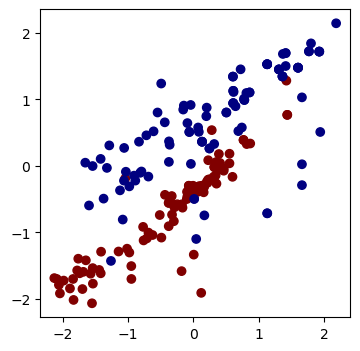

In [2]:
# Load the features and labels from an online text file
url = 'https://ics.uci.edu/~ihler/classes/cs178/data/nyc_housing.txt'
with requests.get(url) as link:
    datafile = StringIO(link.text)
    nych = np.genfromtxt(datafile,delimiter=',')
    nych_X, nych_y = nych[:,:-1], nych[:,-1]

# Process the data to be only two classes and two real-valued & normalized features:
X, y = nych_X[nych_y<2,:2],nych_y[nych_y<2]
X -= X.mean(axis=0,keepdims=True)  # remove mean
X /= X.std(axis=0,keepdims=True)   # & scale
y = 2*y - 1                        # classical binary: positive/negative

# Visualize the resulting dataset:
plt.figure(figsize=(4,4))
plt.scatter(X[:,0],X[:,1],c=y,cmap='jet');

## Problem 1: Logistic Regression

The ``scikit`` package contains several implementations of logistic regression models for classification. In order to emphasize the similarities between different models, we will use the ``SGDClassifier`` object, which is a bit of a misnomer since SGD is an optimization technique, not a model.  The object implements several types of linear classifiers, optimized using SGD or SGD-like training, depending on the loss function selected.

### Problem 1.1: Decision Boundaries

First, let's build a linear classifier and manually set its parameters.  Suppose that we initialize our linear classifier to make it's predictions as,
$$\hat y = T(\ \theta_0 + \theta_1 x_1 + \theta_2 x_2 \ )$$
with $[\ \theta_0, \ \theta_1, \ \theta_2 \ ] = [-2, \ 2, \ 1 \ ]$.

**(a)** What is the decision boundary of this classifier? (Answer in the form $x_2 = a x_1 + b$.)

Since the desicion boundaty satisfies: $0=\theta_0 + \theta_1 x_1 + \theta_2x_2$, we get
$$0 = -2 + 2 x_1 + x_2 \implies x_2 = -2x_1 + 2 . $$

Let's initialize the classifier and look at its decision function.  

We will set the classifer to use the logistic negative log-likelihood surrogate loss (``loss=log_loss``); the other parameters prevent re-initializing the model later (``warm_start=True``) and set the stochastic gradient step size schedule (``learning_rate='adaptive'`` is a simple backoff method, and initial step size ``eta0=1e-3`` is a small initial step size, so we can see the early progress).

**(b)** Add code below to plot your answer above on the decision function and verify that your answer matches ``scikit``'s output:

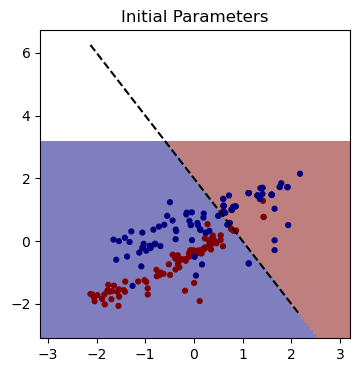

In [3]:
logreg = SGDClassifier(loss='log_loss', warm_start=True, learning_rate='adaptive', eta0 = 1e-3)

# Now let's initialize the model manually:
logreg.classes_ = np.unique(y)       # class IDs from the data
logreg.coef_ = np.array([[2.,1.]])     
logreg.intercept_ = np.array([-2.])   # r(x) = 2*x1 + 1*x2 + (-2)

figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(logreg, X, ax=axes, **plot_kwargs)
axes.scatter(X[:, 0], X[:, 1], c=y, edgecolor=None, s=12, cmap='jet')

### YOUR CODE STARTS HERE

x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -2 * x_vals + 2  # from x₂ = -2x₁ + 2
axes.plot(x_vals, y_vals, color='black', linestyle='--', label='Decision Boundary')
# Plot the line you derived in part 1 on the figure, in an appropriate range of values

### YOUR CODE ENDS HERE

axes.set_title(f'Initial Parameters');

### Problem 1.2: Gradient Optimization

Start training your model using stochastic gradient descent, and looking at the classifier and decision boundary as you progress.  For this part, we use ``partial_fit``, a function that does a single epoch of stochastic gradient descent, and does not reset the internal state of the optimization loop (number of iterations, etc.), so that subsequent calls "pick up" right where the previous calls left off.

We'll initialize the model as before; then, train your model and visualize its current decision function (using ``DecisionBoundaryDisplay``) after each of:
* 1 epoch
* 25 epochs
* 100 epochs
* 1000 epochs (final model)

Note that each call to ``partial_fit`` performs one epoch of SGD.

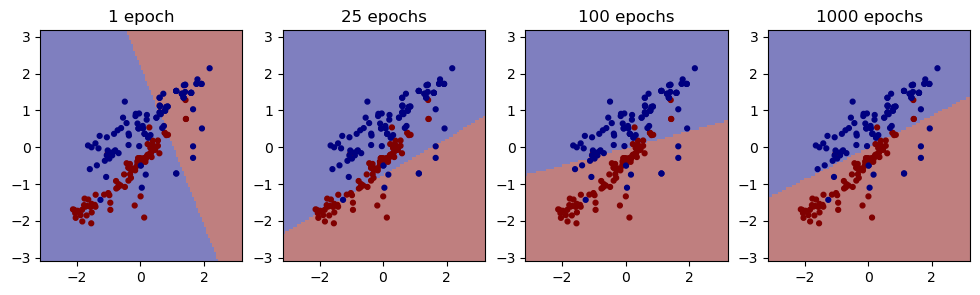

In [4]:
np.random.seed(seed)

logreg = SGDClassifier(loss='log_loss', warm_start=True, learning_rate='adaptive', eta0 = 1e-3)
logreg.coef_ = np.array([[2.,1.]])     
logreg.intercept_ = np.array([-2.])   # r(x) = 2*x1 + 1*x2 + (-2)

plot_iters = [1,25,100,1000]
figure, axes = plt.subplots(1, 4, figsize=(12,3))

### YOUR CODE STARTS HERE

prev = 0
first = True
for ax, n in zip(axes, plot_iters):
    for _ in range(n - prev):
        logreg.partial_fit(X, y, classes=np.unique(y))

    DecisionBoundaryDisplay.from_estimator(logreg, X, ax=ax, **plot_kwargs)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolor=None, s=12, cmap='jet')
    ax.set_title(f"{n} epoch" if n == 1 else f"{n} epochs") #lets make it facny for not good reason
    prev = n
### YOUR CODE ENDS HERE

### Problem 1.3: Evaluation

Using your final model after training, display its learned linear coefficients and evaluate its (training) error rate.

Manually compute the linear response at the point $(x_1,x_2) = (-1,0)$, and use the logistic function to evaluate the model's estimated probability that this point is in each class.  (You can use the model's built-in function ``predict_proba`` to check your answer, if you like.)

In [5]:
# Display model parameters

w = logreg.coef_.ravel()
b = logreg.intercept_[0]
print(f"Final model weights   w = {w}")
print(f"Final model intercept b = {b:.4f}")
print()
# Evaluate model performance
y_hat = logreg.predict(X)
train_err = np.mean(y_hat != y)
print(f"Model training error rate = {train_err:.3f}")
print()

x0 = np.array([-1,0])
z = np.dot(w,x0) + b 
p1 =  1.0 / (1.0 + np.exp(-z)) # sigmoid
p0 = 1- p1

print(f"Final model linear response z = {z:.4f}")
print(f"Manual probs at (-1,0): [P(class 0), P(class 1)] = [{p0:.4f}, {p1:.4f}]")


# Manual computation: linear response and predicted probability at (-1,0)

Final model weights   w = [ 1.50940898 -3.47550824]
Final model intercept b = -0.0233

Model training error rate = 0.095

Final model linear response z = -1.5327
Manual probs at (-1,0): [P(class 0), P(class 1)] = [0.8224, 0.1776]


In [6]:
logreg.predict_proba([[-1,0]]).round(2)  # Evaluate on final model to check your answer

array([[0.82, 0.18]])

## Problem 2: (Linear) Support Vector Machines

As we saw in lecture, a linear support vector machine optimizes the "margin" around the data.  Our current data set is not linearly separable, so we will need to use a "Soft Margin" SVM.  Soft-margin Linear SVMs are equivalent to a linear classifier trained using an L2-regularized hinge loss; so, we can implement the SVM using exactly the same ``SGDClassifier`` model, using the same learner (linear classifier) and an identical learning algorithm (stochastic gradient), but changing the loss function.

To make our model as "close" to a hard-margin SVM as possible, we set the L2 regularization to be very small.  This also can make the optimization a bit slow, so we'll use a lot of iterations and turn off any early stopping criteria.

### Problem 2.1: Training & Evaluation
Fit your model to the data, then print out its linear coefficients and the resulting (training) error rate:

In [7]:
np.random.seed(seed)

learner = SGDClassifier(loss='hinge',             # hinge loss = primal linear SVM form
              penalty='l2',alpha=1e-20,           # small L2 regularization is "closest" to Hard SVM
              learning_rate='adaptive',eta0=1e-3, # same optmization as before
              tol=0.,max_iter=10000,n_iter_no_change=1000)  # prevent any early stopping

### YOUR CODE STARTS HERE

# Train the model, display your parameters & evaluate its performance
learner.fit(X,y)

w = learner.coef_.ravel()
b = learner.intercept_[0]

print(f"Learner weights   w = {w}")
print(f"Learner intercept b = {b:.4f}")
print()
# Evaluate model performance
y_hat = learner.predict(X)
train_err = np.mean(y_hat != y)
print(f"Learner training error rate = {train_err:.3f}")
print()

### YOUR CODE ENDS HERE

Learner weights   w = [ 1.72112436 -2.63600577]
Learner intercept b = 0.1457

Learner training error rate = 0.075



### Problem 2.2: Decision boundary & margins

Now, display the decision function learned by your linear SVM. In addition, on top of the decision boundary plot, display the SVM's margins, i.e.,
$$r(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 = +1$$
and 
$$r(x) = \theta_0 + \theta_1 x_1 + \theta_2 x_2 = -1$$

(Recall that the decision boundary, as you plotted earlier, is given by $r(x)=0$.)

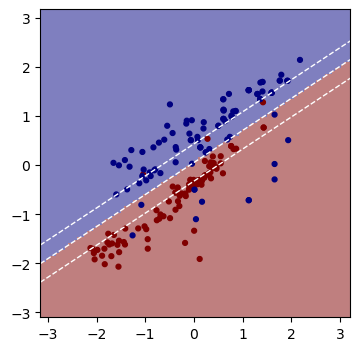

In [8]:
figure, axes = plt.subplots(1, 1, figsize=(4,4))
DecisionBoundaryDisplay.from_estimator(learner, X, ax=axes, **plot_kwargs)
axes.scatter(X[:, 0], X[:, 1], c=y, edgecolor=None, s=12, cmap='jet')

### YOUR CODE STARTS HERE

# Draw (e.g. with dashed lines) the set of points that are on the +1 and -1 margins


w = learner.coef_.ravel()      
b = learner.intercept_[0]      

x1_min, x1_max = axes.get_xlim()
xs = np.linspace(x1_min, x1_max, 200)

#axes.plot(xs, w+b)

if w[1] != 0 :
    # x2 = (t - b - w1*x1)/w2 
    for t, ls in [(-1, '--'), (+1, '--'), (0,'--')]:
        x2 = (t - b - w[0]*xs) / w[1]
        axes.plot(xs, x2, ls, color='w', linewidth=1, label=f"r(x)={t}")
else:
    # x1 = (t - b)/w1
    for t, ls in [(-1, '--'), (+1, '--')]:
        x_vert = (t - b) / w[0]
        axes.axvline(x_vert, linestyle='--', color='w', linewidth=1, label=f"r(x)={t}")
        
        
# (Hint: this is almost the same aws drawing the decision boundary earlier, except that 
#  you need to use your trained parameters, and solve r(x)=+1 and r(x)=-1 instead of r(x)=0.)

### YOUR CODE ENDS HERE

## Problem 3: Feature Expansion
If we feel that our linear classifier is insufficiently flexible, one option is to provide it with more features.  Just like in our linear regression models, additional features, such as polynomial features, make the resulting model more adaptable to the data.

In this problem, we will expand our features using ``PolynomialFeatures``, and look at the resulting logistic regression model's decision function.

Note that, when creating new features, especially high-order polynomials, it is a good idea to scale the data after the feature transform.
As in the HW2 solutions, the easiest way to expand the feature set and rescale the data is to use the ``Pipeline`` object in ``sklearn``.

Adapt the code below to fit and display the decision function for degrees 1, 2, 5, and 20.

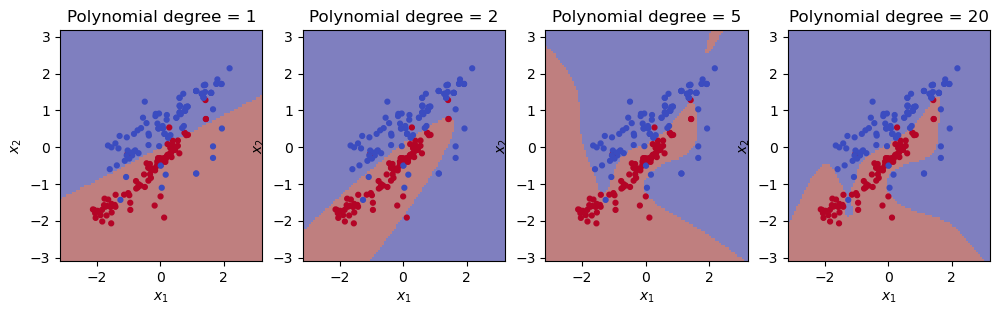

In [9]:
from sklearn.pipeline import Pipeline
np.random.seed(seed)

degrees=[1,2,5,20]
figure,axes = plt.subplots(1,4,figsize=(12,3))

for i,d in enumerate(degrees):
    
# Each item in the pipeline is a pair, (name, transform); the end is (name, learner):
    learner = Pipeline( [('poly',PolynomialFeatures(degree=d)),
                         ('scale',StandardScaler()), 
                         ('logreg',SGDClassifier(loss='log_loss',
                                                 penalty='l2',alpha=1e-20,
                                                 learning_rate='adaptive', eta0=1e-2,
                                                 tol=0.,max_iter=100000,n_iter_no_change=1000))
                        ])

    ### YOUR CODE STARTS HERE
    
    # Fit the model
    learner.fit(X,y)
    # Display the resulting decision function and training data

    ax = axes[i]
    DecisionBoundaryDisplay.from_estimator(learner, X, ax=ax, **plot_kwargs)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=12, edgecolor=None, cmap='coolwarm')
    ax.set_title(f"Polynomial degree = {d}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")

    ### YOUR CODE ENDS HERE

### Problem 3.2: Regularization

Our higher-order models are most likely overfitting (although we can't tell for sure, since we didn't save any data for validation).  Let's re-learn the model using some regularization to see how it affects the resulting decision function.

Try increasing the L2 regularization to ``1e-3``, ``1e-1``, and ``10`` and display the resulting decision functions. Discuss how these compare to each other, and to the (nearly) unregularized version in the previous question.

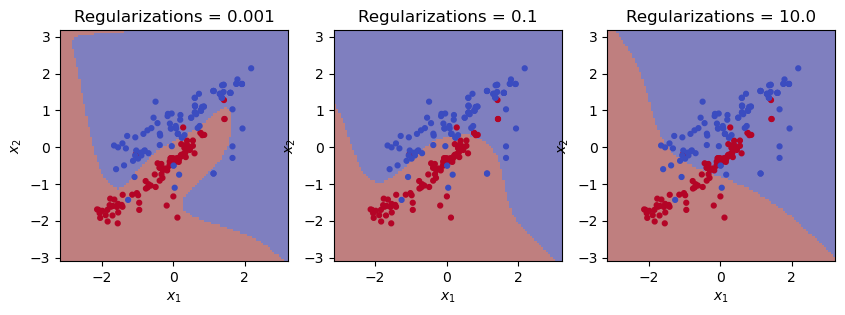

In [10]:
from sklearn.pipeline import Pipeline
np.random.seed(seed)

d = 20
alphas = [1e-3, 1e-1, 10.]
figure,axes = plt.subplots(1,3,figsize=(10,3))

for i,alpha in enumerate(alphas):
    
# Each item in the pipeline is a pair, (name, transform); the end is (name, learner):
    learner = Pipeline( [('poly',PolynomialFeatures(degree=d)),
                         ('scale',StandardScaler()), 
                         ('logreg',SGDClassifier(loss='log_loss',
                                                 penalty='l2',alpha=alpha,
                                                 learning_rate='adaptive', eta0=1e-2,
                                                 tol=0.,max_iter=100000,n_iter_no_change=1000))
                        ])

    ### YOUR CODE STARTS HERE
    
    # Fit the model

    learner.fit(X,y)
    # Display the resulting decision function and training data
    ax = axes[i]
    DecisionBoundaryDisplay.from_estimator(learner, X, ax=ax, **plot_kwargs)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=12, edgecolor=None, cmap='coolwarm')
    ax.set_title(f"Regularizations = {alpha}")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")    
    ### YOUR CODE ENDS HERE

**Answer.** As we see the linear classifayer is not enought and so we need a none-linear classifier. However, in the polynomial case, we see that as the degree is higher we are very likley to overfit; a simillar patterns follows for the regularization terms, as the overfitting gets worse as the regulariation term is larger.

## Problem 4: Logistic Regression on MNIST

Finally, let us now build a linear classifier (specifically, a logistic regression model) on a higher-dimensional, multi-class problem: the MNIST data set. 

The MNIST dataset is an image dataset consisting of 70,000 hand-written digits (from 0 to 9), each of which is a 28x28 grayscale image. For each image, we also have a label, corresponding to which digit is written.

### Problem 4.0: Setting up the Data
First, we'll load our dataset, split it into a training set and a testing set, and do some basic pre-processing. Here you are given code that does this for you, and you only need to run it.

In [11]:
# Load the features and labels for the MNIST dataset
# This might take a minute to download the images.
X, y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

# Convert labels to integer data type
y = y.astype(int)

Each data point in the MNIST dataset is 784-dimensional, with each feature corresponding to a pixel intensity of a $28\times 28$ scan of a digit.  To visualize a data point, we can re-shape the feature vector into the shape of the image, and then display it using `imshow`:

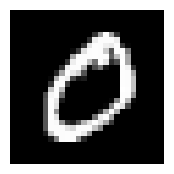

In [12]:
plt.figure(figsize=(2,2))
plt.imshow( X[1,:].reshape(28,28) , cmap='gray');
plt.axis('off');

As before, we will normalize the data before learning using the scikit-learn class ``StandardScaler`` to standardize both the training and testing features. Notice that we **only** fit the `StandardScaler` on the training data, and *not* the testing data.

In [13]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, random_state=seed, shuffle=True)

X_tr_orig, X_te_orig = X_tr, X_te   # Save a copy of these for later visualization

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)     # We can forget about the original values & work
X_te = scaler.transform(X_te)     #  just with the transformed values from here
                                  # (This does make it harder to visualize a data point, though)

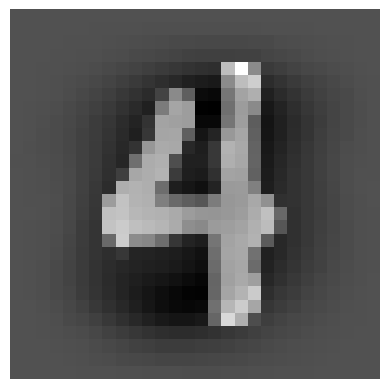

In [14]:
# Testing for myself the last comment about harder to visualize.
plt.imshow( X_tr[1,:].reshape(28,28) , cmap='gray');
plt.axis('off');

### Problem 4.1: Initial Training (10 points)
For this part of the problem, you will train on **just** the first 10000 training data points, and compute the training and test error rates.  
- Be sure to set the random seed with ``random_state=seed`` for consistency.
- Other than the random seed, just use the default values of the learner for this part.
- Here, the training error rate is defined on the first 10k data points (i.e., the points that were used for training the model
- The test error rate is defined on the full test data from your split.

In [15]:
m_tr = 10000

X_tr_subset = X_tr[:m_tr, :]
y_tr_subset = y_tr[:m_tr]

# Construct a logistic regression classifier (random_state = seed)
learner_mnist = LogisticRegression(random_state=seed)

### YOUR CODE STARTS HERE ###

# Fit your model to the (small subset of the) training data
learner_mnist.fit(X_tr_subset, y_tr_subset)

# Compute the training error (on the small training subset)
yhat_tr = learner_mnist.predict(X_tr_subset)
train_err = np.mean(yhat_tr != y_tr_subset)

# and testing error (on the test data)
yhat_te = learner_mnist.predict(X_te)
test_err = np.mean(yhat_te != y_te)

print(f"Training error (first 10k only): {train_err:.4f}")
print(f"Test error     (full test set) : {test_err:.4f}")


### YOUR CODE ENDS HERE ###

Training error (first 10k only): 0.0014
Test error     (full test set) : 0.1204


Your model should learn a set of linear coefficients for each of the 10 classes:

In [16]:
print(f'Coefficients shape: {learner_mnist.coef_.shape}')    # should be 10 x 784
print(f'Intercepts shape  : {learner_mnist.intercept_.shape}') # should be 10

Coefficients shape: (10, 784)
Intercepts shape  : (10,)


### Problem 4.2: Regularization (10 points)

Suspecting that we are overfitting to our limited data set, we decide to try to use regularization.  (This should reduce our model's variance, and thus its tendency to overfit.)  Try re-training your logistic regression model at various levels of regularization.  

The ``LogisticRegression`` class in ``sklearn`` takes an "inverse regularization" parameter, ``C`` (effectively the same as the value $R$ we saw in soft-margin Support Vector Machines).  Re-train your model with values of $C \in \{.0001, .001, .01, .1, 1.0, 10.\}$ and compute the training and test error rates of each setting.  Plot the training and test error rates together as a function of $C$ (plot using ``semilogx`` for it to look nice) and state what value of $C$ you would select and why.

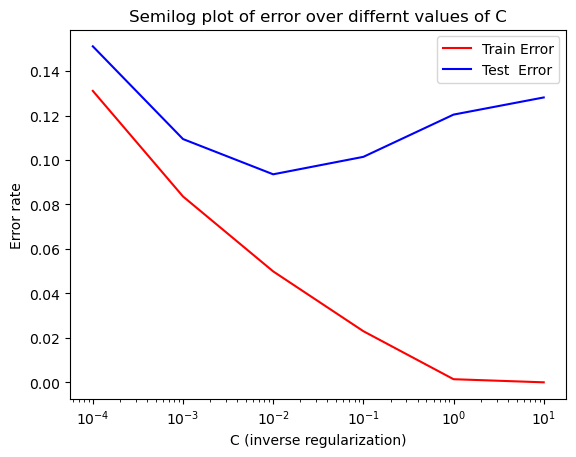

In [17]:
m_tr = 10000
C_vals = [.0001,.001,.01,.1,1.,10.]; 

### YOUR CODE STARTS HERE ###

Train_err=[]
Test_err =[]

for C in C_vals:

    # Train a logistic regression model with each inverse regularization C
    learner_mnist = LogisticRegression(random_state=seed,C=C)
    learner_mnist.fit(X_tr_subset, y_tr_subset)

    # Compute the training and test error rates at each value of C
    yhat_tr = learner_mnist.predict(X_tr_subset)
    train_err = np.mean(yhat_tr != y_tr_subset)

    # and testing error (on the test data)
    yhat_te = learner_mnist.predict(X_te)
    test_err = np.mean(yhat_te != y_te)
    
    Train_err.append(train_err)
    Test_err.append(test_err)

    #print(f"Training error (first 10k only): {train_err:.4f} at C={C}")
    #print(f"Test error     (full test set) : {test_err:.4f} at C={C}")

# Plot the resulting performance as a function of C
    
plt.semilogx(C_vals, Train_err, color='red',label='Train Error')
plt.semilogx(C_vals, Test_err, color='blue',label='Test  Error')
plt.title("Semilog plot of error over differnt values of C")
plt.xlabel('C (inverse regularization)')
plt.ylabel('Error rate')
plt.legend()
plt.show()
### YOUR CODE ENDS HERE ###

**Answer.** While the error rate of the train data keeps deacreasing as $C$ deacreases, the test data seems to reach a minimum at **C=0.01**, and therefore that would be the choosen $C$.

### Problem 4.3: Interpreting the weights (5 points)
Now that we have a model that we believe might perform well, let's try to understand what propertes of the data it is using to make its predictions.  Since our model is just using a linear combination of the input pixels, we can display the coefficient (slope) associated with each pixel, to see whether that pixel's being bright (high value) is positively associated with a given class, or is negatively associated with that class.

First, re-train your model using your selected value of $C$.

In [18]:
### YOUR CODE START HERE ###

C=0.01


# Re-train your model with your selected value of C 
learner_mnist = LogisticRegression(random_state=seed,C=C)
learner_mnist.fit(X_tr_subset, y_tr_subset)

# Compute the training and test error rates at each value of C
yhat_tr = learner_mnist.predict(X_tr_subset)
train_err = np.mean(yhat_tr != y_tr_subset)

# and testing error (on the test data)
yhat_te = learner_mnist.predict(X_te)
test_err = np.mean(yhat_te != y_te)

Train_err.append(train_err)
Test_err.append(test_err)

print(f"Training error (first 10k only): {train_err:.4f} at C={C}")
print(f"Test error     (full test set) : {test_err:.4f} at C={C}")

### YOUR CODE ENDS HERE ###

Training error (first 10k only): 0.0499 at C=0.01
Test error     (full test set) : 0.0936 at C=0.01


Run the provided code to display the coefficients of the first four classes' linear responses, re-shaped to the same size as the input image.  (Here, red is positive, blue is negative, and white is zero.)  Do the responses make sense?  Discuss.

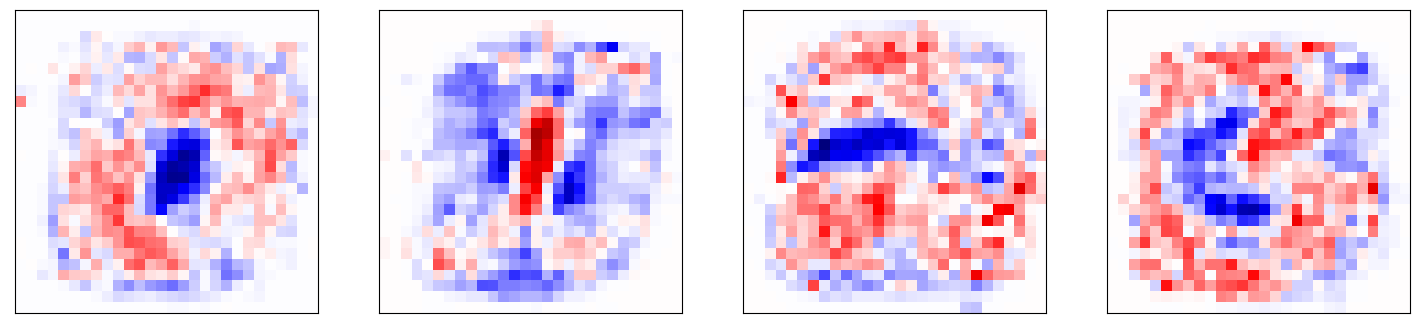

In [19]:
fig, ax = plt.subplots(1,4, figsize=(18,8))

mu = learner_mnist.coef_.mean(0).reshape(28,28)
for i in range(4):
    ax[i].imshow(learner_mnist.coef_[i,:].reshape(28,28)-mu,cmap='seismic',vmin=-.25,vmax=.25); 
    ax[i].set_xticks([]); ax[i].set_yticks([]);

**Answer.** The reasult somewhat make sense for a desciion functio,as while it is hard to read, you can make out the numbers without too much of an issue.

### Problem 4.4

The multilogistic classifier uses the negative log-likelihood loss, just like the logistic classifier, but produces a predicted probability for each class based on that class's linear response.

In this problem, we'll consider a particular (somewhat ambiguous) data point:

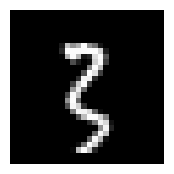

In [20]:
idx = 10592
plt.figure(figsize=(2,2))
plt.imshow( X_tr_orig[idx,:].reshape(28,28) , cmap='gray');  # Use "orig" to show it before rescaling
plt.axis('off');

**(a)** Using your model parameters, **manually** compute the linear response values for each of the 10 classes on this data point.  (You can do this easily using matrix multiplication and addition of arrays.)

In [21]:
# img = X_tr[idx,:]
# W@img+b

In [22]:
X1 = X_tr_orig[idx,:]
W = learner_mnist.coef_ 
b = learner_mnist.intercept_
lines = W@X1 +b

classes = np.arange(1, 11)

print("Linear responses (logits) per class.")
for line, classs in zip(lines,classes):
    print(f"Class {classs}: response: {line}")


Linear responses (logits) per class.
Class 1: response: -66.11391856187545
Class 2: response: -5.052236607887112
Class 3: response: 127.90737827683606
Class 4: response: 233.38025537928831
Class 5: response: -504.6132224373121
Class 6: response: -92.51887503803455
Class 7: response: -31.07281368987016
Class 8: response: -86.13373191228213
Class 9: response: 302.3373053035656
Class 10: response: 121.87985928757224


**(b)** Use the multi-logit or ``softmax`` transformation to convert these responses into estimated class probabilities.

In [23]:
def softmax(z):
    z = np.asarray(z)
    z_shift = z - np.max(z)
    expz = np.exp(z_shift)
    return expz / expz.sum()

probs = softmax(lines)

print("Softmax probabilities per class.")
for prob, classs in zip(probs,classes):
    print(f"Class {classs}: Softmax probability: {prob}")
    

Softmax probabilities per class.
Class 1: Softmax probability: 9.6308944835501e-161
Class 2: Softmax probability: 3.1799343430822004e-134
Class 3: Softmax probability: 1.7621594916595172e-76
Class 4: Softmax probability: 1.1280639734781957e-30
Class 5: Softmax probability: 0.0
Class 6: Softmax probability: 3.2820087324547346e-172
Class 7: Softmax probability: 1.5915676767311426e-145
Class 8: Softmax probability: 1.9461313913152006e-169
Class 9: Softmax probability: 1.0
Class 10: Softmax probability: 4.2493937705407677e-79


**(c)** Do these probabilities make sense, given the observation? Discuss briefly.

The sime of all probabilities is 1. The values themself make sense as the highest probabilities are for 2, 3, and  8; which if we look at how they are written out they are quite simillar.

**Note:** To check your answer, you can compare to the values given by the learner's built-in ``predict_proba()`` function:

In [24]:
learner_mnist.predict_proba(X_tr[idx:idx+1,:]).round(2)

array([[0.01, 0.17, 0.12, 0.21, 0.  , 0.12, 0.02, 0.15, 0.07, 0.12]])

### Problem 4.5: Learning Curves (10 points)
Another way to reduce overfitting is to increase the amount of data used for training the model (if possible).  Build a logistic regression model, but with no regularization

- Train a logistic regression classifier (with the default settings in sklearn) using the first `m_tr` feature vectors in `X_tr`, where `m_tr = [100, 1000, 5000, 10000, 20000, 50000, 63000]` .You should use the `LogisticRegression` class from scikit-learn in your implementation. **Make sure to use the argument `random_state=seed` for reproducibility.**
- Create a plot of the training error and testing error for your logistic regression model as a function of the number of training data points. Be sure to include an x-label, y-label, and legend in your plot. Use a log-scale on the x-axis. Give a short (one or two sentences) description of what you see in your plot.
- Add a comment with your thoughts after the plot: although we ran out of data at 63k examples, can you tell how much additional data could help, with this model?

For size: 100
Train errors: 0.0
Test  errors: 0.312

For size: 1000
Train errors: 0.0
Test  errors: 0.1487

For size: 5000
Train errors: 0.0
Test  errors: 0.139

For size: 10000
Train errors: 0.0
Test  errors: 0.1347

For size: 20000
Train errors: 0.0239
Test  errors: 0.1193

For size: 50000
Train errors: 0.0534
Test  errors: 0.0869

For size: 63000
Train errors: 0.0572
Test  errors: 0.0829



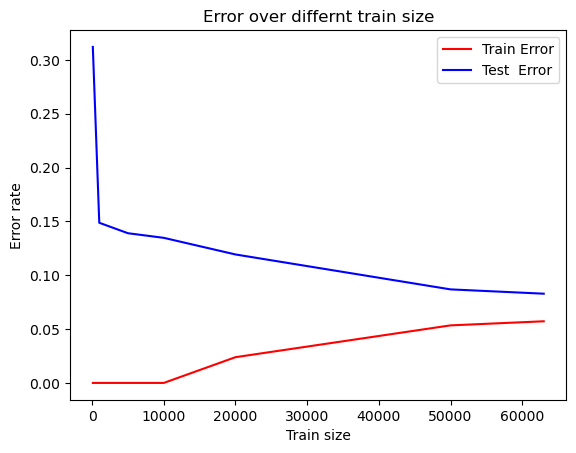

In [25]:
train_sizes = [100, 1000, 5000, 10000, 20000, 50000, 63000]

C = np.inf      # No regularization!

### YOUR CODE STARTS HERE ###

# Train a logistic regression model with each data size m and C=infinity


Train_err=[]
Test_err =[]

for m in train_sizes:
    Xm, ym = X_tr[:m], y_tr[:m]

    # Train a logistic regression model with each inverse regularization C
    learner_mnist = LogisticRegression(random_state=seed,C=C)
    learner_mnist.fit(Xm ,ym)

    # Compute the training and test error rates at each value of C
    yhat_tr = learner_mnist.predict(Xm)
    yhat_te = learner_mnist.predict(X_te)
    
 
    # Compute the training and test error rates
    train_err = np.mean(yhat_tr != ym)
    test_err = np.mean(yhat_te != y_te)
    
    
    Train_err.append(train_err)
    Test_err.append(test_err)
    
#     train_err.append(np.mean(yhat_tr != ym))
#     test_err.append(np.mean(yhat_te != y_te))

    print(f"For size: {m}")
    print(f"Train errors: {np.round(train_err, 4)}")
    print(f"Test  errors: {np.round(test_err,  4)}")
    print()


# Plot the resulting performance as a function of m

plt.plot(train_sizes, Train_err, color='red',label='Train Error')
plt.plot(train_sizes, Test_err, color='blue',label='Test  Error')
plt.title("Error over differnt train size")
plt.xlabel('Train size')
plt.ylabel('Error rate')
plt.legend()
plt.show()

### YOUR CODE ENDS HERE ###

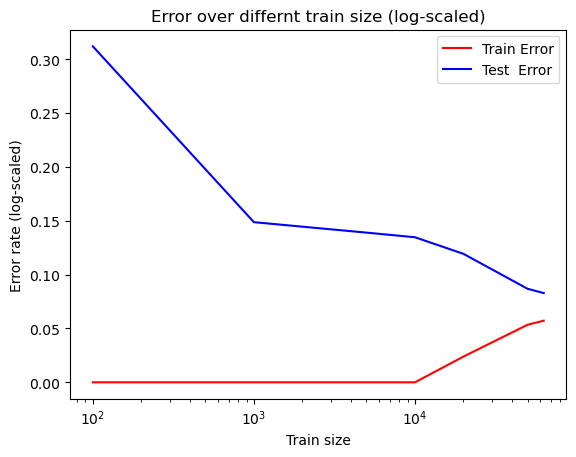

In [28]:
plt.semilogx(train_sizes, Train_err, color='red',label='Train Error')
plt.semilogx(train_sizes, Test_err, color='blue',label='Test  Error')
plt.title("Error over differnt train size (log-scaled)")
plt.xlabel('Train size')
plt.ylabel('Error rate (log-scaled)')
plt.legend()
plt.show()

**Answer.** As we see from the graph, for h test error, there is an initial large drop, and afterwards a slower decline, while the train error initially small, grows over time. We see that as we take larger train test, we tend to overfit the training data, but the overall model gets better for the test-data as we have a more accurate representation of the overall data we work with.

<div>
    <img src="data:image/svg+xml,%3C%3Fxml%20version%3D%221.0%22%20encoding%3D%22UTF-8%22%20standalone%3D%22no%22%3F%3E%0A%3C%21DOCTYPE%20svg%20PUBLIC%20%22-//W3C//DTD%20SVG%201.1//EN%22%20%22http%3A//www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd%22%3E%0A%3Csvg%20stroke-miterlimit%3D%2210%22%20style%3D%22fill-rule%3Anonzero%3Bclip-rule%3Aevenodd%3Bstroke-linecap%3Around%3Bstroke-linejoin%3Around%3B%22%20version%3D%221.1%22%20viewBox%3D%220%200%20288%2072%22%20xml%3Aspace%3D%22preserve%22%20xmlns%3D%22http%3A//www.w3.org/2000/svg%22%20xmlns%3Axlink%3D%22http%3A//www.w3.org/1999/xlink%22%3E%0A%3Cdefs/%3E%0A%3Cg%20id%3D%22Layer-1%22%3E%0A%3Cpath%20d%3D%22M34.042%2035.8741C45.8469%2023.244%2031.1794%2022.6473%2024.2857%2024.1167C17.3921%2025.5861-0.960215%2033.2987%206.07817%2043.4256C13.1166%2053.5525%2023.0237%2056.9377%2052.2446%2053.4091C81.4656%2049.8804%2097.2436%2032.811%20122.962%2029.3111C148.681%2025.8112%20155.118%2039.4093%20155.118%2039.4093%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3Cpath%20d%3D%22M254.053%2040.6889C242.328%2053.1071%20256.999%2053.6247%20263.883%2052.1549C270.768%2050.685%20289.071%2043.0512%20281.969%2033.1691C274.868%2023.287%20264.94%2020.0179%20235.741%2023.6051C206.543%2027.1922%20190.872%2043.9744%20165.176%2047.5176C139.48%2051.0607%20132.957%2037.7776%20132.957%2037.7776%22%20fill%3D%22none%22%20opacity%3D%221%22%20stroke%3D%22%23000000%22%20stroke-linecap%3D%22butt%22%20stroke-linejoin%3D%22round%22%20stroke-width%3D%223%22/%3E%0A%3C/g%3E%0A%3C/svg%3E%0A" width="200"/>
</div>

---
### Statement of Collaboration (5 points)

It is **mandatory** to include a Statement of Collaboration in each submission, with respect to the guidelines below. Include the names of everyone involved in the discussions (especially in-person ones), and what was discussed.

All students are required to follow the academic honesty guidelines posted on the course website. For
programming assignments, in particular, I encourage the students to organize (perhaps using EdD) to
discuss the task descriptions, requirements, bugs in my code, and the relevant technical content before they start
working on it. However, you should not discuss the specific solutions, and, as a guiding principle, you are not
allowed to take anything written or drawn away from these discussions (i.e. no photographs of the blackboard,
written notes, referring to EdD, etc.). Especially after you have started working on the assignment, try
to restrict the discussion to EdD as much as possible, so that there is no doubt as to the extent of your
collaboration.

**Aswer.** Emeric Battaglia and I worked independently on the homework, and then confirmed our results were similar. He pointed I didnt plot my graph in log-scaled for 4.5, and so I corrected it.